In [1]:
import mysql.connector
import pandas as pd

In [14]:

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)

# Query only relevant columns
query = """
SELECT matched_keywords, sentiment_score,
       price_change_pct_1h, price_change_pct_4h,
       price_change_pct_24h, price_change_pct_4d,
       price_change_pct_7d
FROM headlines
WHERE sentiment_score IS NOT NULL
  AND matched_keywords IS NOT NULL
  AND matched_keywords != 'none'
  AND date >= CURDATE() - INTERVAL 10 DAY
  AND WEEKDAY(date) < 5;
"""

df = pd.read_sql(query, conn)

conn.close()

# Preview the data
print(df.head())


    matched_keywords  sentiment_score  price_change_pct_1h  \
0        rise, crash           -0.350                 1.10   
1  announces closing           -0.200                -0.30   
2  growth, potential            0.575                 0.18   
3          agreement            0.300                -1.48   
4             profit            0.950                 1.36   

   price_change_pct_4h  price_change_pct_24h  price_change_pct_4d  \
0                 1.32                  1.97                 3.64   
1                -1.20                 -0.90                 0.60   
2                 1.33                  2.14                 1.87   
3                -7.85                 -3.70                -5.33   
4                 0.97                  5.56                 6.14   

  price_change_pct_7d  
0                None  
1                None  
2                None  
3                None  
4                None  


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_80570/3246651082.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [15]:
#Duplicate rows for each keyword
df_exploded = df.copy()
df_exploded['matched_keywords'] = df_exploded['matched_keywords'].str.split(', ')

# Explode the df, each keyword has its own row
df_exploded = df_exploded.explode('matched_keywords').reset_index(drop=True)

#Grouping and calculate average price changes
keyword_impact = df_exploded.groupby('matched_keywords').agg({
    'sentiment_score': 'mean',
    'price_change_pct_1h': 'mean',
    'price_change_pct_4h': 'mean',
    'price_change_pct_24h': 'mean',
    'price_change_pct_4d': 'mean',
    'price_change_pct_7d': 'mean',
    'matched_keywords': 'count'  # count of appearances
}).rename(columns={'matched_keywords': 'occurrences'})

# Sort by 24h price change for now
keyword_impact_sorted = keyword_impact.sort_values(by='price_change_pct_24h', ascending=False)

filtered = keyword_impact_sorted[keyword_impact_sorted['occurrences'] >= 2]
display(filtered.sort_values(by='price_change_pct_24h', ascending=False))

# Display the result 
#display(keyword_impact_sorted.head(20))  # top 20 most impactful keywords by 24h price change


,sentiment_score,price_change_pct_1h,price_change_pct_4h,price_change_pct_24h,price_change_pct_4d,price_change_pct_7d,occurrences
matched_keywords,,,,,,,
promotion,0.260000,0.013333,1.073333,3.650000,-0.570000,NaN,5
secures,0.338931,-0.582308,2.111538,3.447308,0.822500,NaN,29
jumps,0.642043,0.156111,0.420000,2.450556,2.498182,NaN,23
winning,0.625000,1.415000,0.422500,2.396667,1.230000,NaN,4
plummeted,-1.000000,0.750000,0.950000,2.253333,0.940000,NaN,3
launch,0.465546,-0.174086,0.528280,2.025376,2.822241,NaN,108
partners with,0.346875,0.482000,1.070000,1.900000,1.022000,NaN,16
joint venture,0.350000,1.940000,2.345000,1.790000,3.710000,NaN,2
positive,0.516667,0.701667,0.911667,1.613333,3.423333,NaN,12


DISPLAYING SEPARATE TABLES FOR POSITIVE VS. NEGATIVE SENTIMENT

#Positive vs Negative Sentiment Keyword Impact (24-Hour Returns)

- I split the dataset into two tables: one for positive sentiment keywords and one for negative ones, sorted by their average 24-hour price impact.
- This helps identify which specific words drive the strongest reactions in the market
- I ensured both tables are drawn from headlines within the last 7 business days, making the analysis more timely and relevant.

In [16]:
# Filter by occurrences first
filtered = keyword_impact_sorted[keyword_impact_sorted['occurrences'] >= 2]

# Split into positive and negative sentiment
positive = filtered[filtered['sentiment_score'] > 0]
negative = filtered[filtered['sentiment_score'] < 0]

pd.set_option('display.max_rows', None)

# Display top movers
display(positive.sort_values(by='price_change_pct_24h', ascending=False))
display(negative.sort_values(by='price_change_pct_24h'))



,sentiment_score,price_change_pct_1h,price_change_pct_4h,price_change_pct_24h,price_change_pct_4d,price_change_pct_7d,occurrences
matched_keywords,,,,,,,
promotion,0.260000,0.013333,1.073333,3.650000,-0.570000,NaN,5
secures,0.338931,-0.582308,2.111538,3.447308,0.822500,NaN,29
jumps,0.642043,0.156111,0.420000,2.450556,2.498182,NaN,23
winning,0.625000,1.415000,0.422500,2.396667,1.230000,NaN,4
launch,0.465546,-0.174086,0.528280,2.025376,2.822241,NaN,108
partners with,0.346875,0.482000,1.070000,1.900000,1.022000,NaN,16
joint venture,0.350000,1.940000,2.345000,1.790000,3.710000,NaN,2
positive,0.516667,0.701667,0.911667,1.613333,3.423333,NaN,12
approval,0.552615,1.216667,0.428333,1.412500,0.645714,NaN,13


,sentiment_score,price_change_pct_1h,price_change_pct_4h,price_change_pct_24h,price_change_pct_4d,price_change_pct_7d,occurrences
matched_keywords,,,,,,,
announces closing,-0.200000,-2.153333,-3.030000,-3.563333,0.600000,NaN,3
loss,-0.514364,0.623077,-0.778462,-2.129231,3.552500,NaN,22
crash,-0.625000,0.485000,-1.257500,-1.908750,0.692857,NaN,8
investigation,-0.800000,0.320000,0.245000,-1.750000,-2.100000,NaN,2
misses,-0.522333,-0.235000,-0.350000,-1.470000,0.615000,NaN,3
slashes,-0.366667,0.293333,1.070000,-1.376667,0.000000,NaN,3
miss,-0.504902,-0.186667,-0.535833,-0.583333,-0.733333,NaN,41
sue,-0.507500,0.038000,-0.359000,-0.554000,0.427143,NaN,10
selloff,-0.675000,0.030000,-0.365000,-0.520000,NaN,NaN,4


Bar Chart

<Axes: xlabel='price_change_pct_24h', ylabel='matched_keywords'>

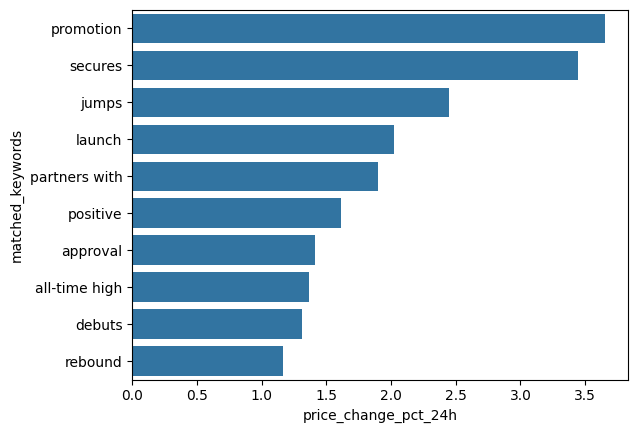

In [17]:
import seaborn as sns
top_keywords = keyword_impact_sorted[keyword_impact_sorted['occurrences'] >= 5]
top_keywords = top_keywords.sort_values(by='price_change_pct_24h', ascending=False).head(10)
sns.barplot(x='price_change_pct_24h', y='matched_keywords', data=top_keywords)


This chart ranks the top 10 positive keywords based on their average 24-hour price change
- These words may act as high-signal indicators for upward movement following headline sentiment.
- Shows early signs of which words might hold real predictive power.

In [22]:
def bucket(score):
    if score > 0.2:
        return 'positive'
    elif score < -0.2:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_group'] = df['sentiment_score'].apply(bucket)


In [23]:
grouped = df.groupby('sentiment_group')[
    ['price_change_pct_1h', 'price_change_pct_4h', 'price_change_pct_24h', 'price_change_pct_4d']
].mean()

display(grouped)


,price_change_pct_1h,price_change_pct_4h,price_change_pct_24h,price_change_pct_4d
sentiment_group,,,,
negative,0.040671,0.094594,0.253498,1.306506
neutral,-0.071238,-0.273267,-0.196617,1.103051
positive,-0.087016,0.060551,0.380945,1.350751


- I grouped headlines into positive, neutral, and negative based on sentiment score thresholds.
- Positive headlines had the highest average return over time, especially after 24 hours 
- Negative headlines still showed small average gains by Day 4, showing possible overreactions.
- Suggests that sentiment scores have predictive value, particularly over longer windows like 4 days.

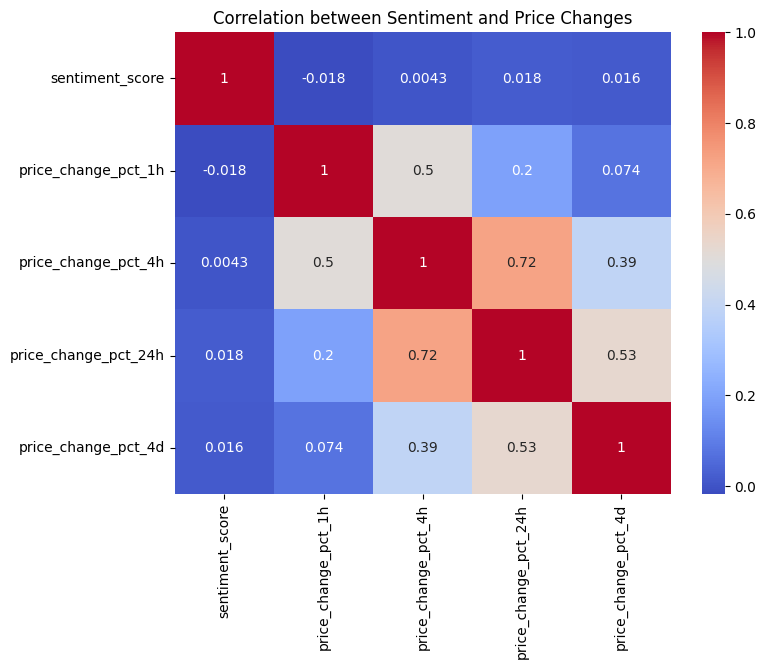

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df[['sentiment_score', 'price_change_pct_1h', 'price_change_pct_4h',
                'price_change_pct_24h', 'price_change_pct_4d']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Sentiment and Price Changes")
plt.show()



- Shows correlation between sentiment scores and stock price changes across multiple timeframes.
- Price change intervals are more strongly correlated with each other (4h and 24h = 0.72), showing consistent movement patterns.
- Weak correlation between sentiment and 1h returns suggests that short-term market reactions may be noisy
- the heatmap supports the idea that sentiment has more influence on medium-term price movement than immediate reaction.
